# Modified by Alex Gagliano to estimate the extinction of SN 2020oi
# Date: 03 March, 2021

In [492]:
# Step 1 -- Estimate the date of B, g, and r maximum
#https://www.aanda.org/articles/aa/pdf/2018/01/aa30843-17.pdf
#check for these to compare
#reddening laws
#extinction.fitzpatrick99(wave, a_v[, r_v, unit])
#Maria -- everyone assumes a Milky Way law!
#

In [493]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
from astropy.io import ascii
from astropy.table import Table
import sys
from scipy.interpolate import interp1d
from astropy.time import Time

GP_results = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/interpolated_lcs/GPResults_2020oi_withSBO2_Trunc.csv")

#spectral epochs
specMJD = np.array([58857.3, 58864.6, 58868.6, 58870.5, 58872.4, 58875. , 58876.7,
       58879.4, 58880.3, 58892. , 58895. , 58995.6])

Lbol = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/scripts/superbol/SBO_input/superbol_output_2020oi/logL_bb_2020oi_AUBgVriz.txt", delimiter='\t', header=None, names=['MJD', 'logL', 'logLerr'])
peak = Lbol.loc[Lbol['logL'] == np.nanmax(Lbol['logL']), 'MJD'].values[1]

specPhase = specMJD - peak

In [494]:
specPhase_used = specPhase[(specPhase >= 0) & (specPhase <= 20.)]
specMJD_used = specMJD[(specPhase >= 0) & (specPhase <= 20.)]
t = Time(specMJD_used, format='mjd')
specDate_used = t.to_value('datetime')
#get the spectra spanning the 20 days following peak considered by the color curves
specDate_used

array([datetime.datetime(2020, 1, 20, 14, 24),
       datetime.datetime(2020, 1, 22, 12, 0),
       datetime.datetime(2020, 1, 24, 9, 36),
       datetime.datetime(2020, 1, 27, 0, 0),
       datetime.datetime(2020, 1, 28, 16, 48),
       datetime.datetime(2020, 1, 31, 9, 36),
       datetime.datetime(2020, 2, 1, 7, 12)], dtype=object)

(58855.0, 58900.0)

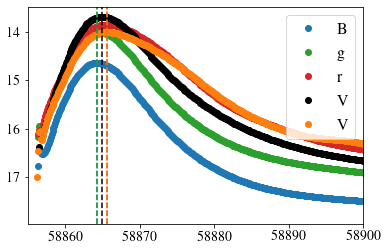

In [495]:
Bpeak_MJD = GP_results.loc[GP_results['B_LC'] == np.nanmin(GP_results['B_LC']), 'MJD'].values[0]
gpeak_MJD = GP_results.loc[GP_results['gp_LC'] == np.nanmin(GP_results['gp_LC']), 'MJD'].values[0]
rpeak_MJD = GP_results.loc[GP_results['rp_LC'] == np.nanmin(GP_results['rp_LC']), 'MJD'].values[0]
Vpeak_MJD = GP_results.loc[GP_results['V_LC'] == np.nanmin(GP_results['V_LC']), 'MJD'].values[0]
ipeak_MJD = GP_results.loc[GP_results['i_LC'] == np.nanmin(GP_results['i_LC']), 'MJD'].values[0]

plt.plot(GP_results['MJD'], GP_results['B_LC'], 'o', label='B', c='tab:blue')
plt.plot(GP_results['MJD'], GP_results['gp_LC'], 'o', label='g', c='tab:green')
plt.plot(GP_results['MJD'], GP_results['rp_LC'], 'o', label='r', c='tab:red')
plt.plot(GP_results['MJD'], GP_results['V_LC'], 'o', label='V', c='k')
plt.plot(GP_results['MJD'], GP_results['i_LC'], 'o', label='V', c='tab:orange')

plt.axvline(x=Bpeak_MJD, c='tab:blue', ls='--')
plt.axvline(x=gpeak_MJD, c='tab:green', ls='--')
plt.axvline(x=rpeak_MJD, c='tab:red', ls='--')
plt.axvline(x=Vpeak_MJD, c='k', ls='--')
plt.axvline(x=ipeak_MJD, c='tab:orange', ls='--')

plt.legend(fontsize=16)
plt.gca().invert_yaxis()
plt.xlim((58855, 58900))

In [496]:
print("B-peak occurs at MJD %.2f.\n" %Bpeak_MJD)
print("g-peak occurs at MJD %.2f.\n" %gpeak_MJD)
print("r-peak occurs at MJD %.2f.\n" %rpeak_MJD)
print("V-peak occurs at MJD %.2f.\n" %Vpeak_MJD)
print("i-peak occurs at MJD %.2f.\n" %ipeak_MJD)

B-peak occurs at MJD 58864.23.

g-peak occurs at MJD 58864.23.

r-peak occurs at MJD 58865.63.

V-peak occurs at MJD 58864.99.

i-peak occurs at MJD 58865.63.



# Version 2 Extinction Fitting:
Modifications:
* (1) Based only on Swope and LCOGT data.
* (2) Uses all of BVgri. 
* (3) Calculates based only on times of observed colors. 
* (4) Takes errors on the observed colors into account. 

Calculated Dates of Maximum: By fitting low-order polynomicals to the early light curves, we calculate the following days of maximum:
* B-band: 58864.71
* g-band: 58864.71
* r-band: 58865.50

Dates of two spectra used to calculate the extinction correction coefficients:
* Jan 2nd FLOYDS: 58850.0 (-4.28, -4.89, -6.21)
* Jan 27th lris: 58875.0 (20.72, 20.11, 18.79)

# Define some Functions:

In [497]:
#Cardelli Extinction for spectra:
from extinction import ccm89, apply, remove

#new cardelli law
def Cardelli(wave,flux,Av,Rv):
    return remove(ccm89(wave, Av, Rv), flux)
    
#def Cardelli(wave,flux,Av,Rv):
#    '''Will de-redden an input spectrum based on the Cardelli law:
#    
#    Parameters:
#    wave (angstrom): wavelengths of input spectrum in Angstrom
#    flux (erg/s/cm/Ang): flux of spectrum; scaled version of this flux are fine.
#    Av:
#    Rv:
    
#    Returns: a new flux array in same units as input
#    '''

#    wave_micon=wave*1.0e-4
#    wave_inverse=1.0/wave_micon
    
#    A_lambda=np.zeros(len(wave))
#    ax=np.zeros(len(wave))
#    bx=np.zeros(len(wave))
    
#    for i in range(len(wave)):
#        if((wave_inverse[i] > 0.3) and (wave_inverse[i] < 1.1)):
#            ax[i]=0.574*wave_inverse[i]**1.61
#            bx[i]=-0.527*wave_inverse[i]**1.61
#        if((wave_inverse[i] > 1.1) and (wave_inverse[i] < 3.3)):
#            y=wave_inverse[i] - 1.82
#            ax[i]=1+ 0.17699*y - 0.50447*y**2. - 0.02427*y**3.+0.72085*y**4.+0.01979*y**5.-0.77530*y**6.+0.32999*y**7.
#            bx[i]=1.41338*y+2.28305*y**2.+1.07233*y**3.-5.38434*y**4.-0.62251*y**5.+5.30260*y**6.-2.09002*y**7.
#        if((wave_inverse[i] > 3.3) and (wave_inverse[i] < 8.0)):
#            if(wave_inverse[i] > 5.9):
#                Fa=-0.04473*(wave_inverse[i] - 5.9)**2.-0.009779*(wave_inverse[i]-5.9)**3.
#                Fb=0.2130*(wave_inverse[i] - 5.9)**2. +0.1207*(wave_inverse[i] -5.9)**3.
#            else:
#                Fa = 0.0
#                Fb = 0.0

#            ax[i]=1.752 - 0.316*wave_inverse[i]-0.104/((wave_inverse[i]-4.67)**2.+0.341) +Fa
#            bx[i]=-3.090+1.825*wave_inverse[i]+1.206/((wave_inverse[i] - 4.62)**2.+0.263) +Fb

#    A_lambda=(ax+bx/Rv)*Av
#    #print(A_lambda)
#    NewSpec=flux*10.**(0.4*A_lambda)
#    results = NewSpec
#    return results

In [498]:
#Synthetic photometry in bands of interest (ugrizBV):
base = "Filters/"
u_filt = ascii.read(base+'SLOAN_SDSS.u_AB.dat', delimiter=' ',comment=';')
B_filt = ascii.read(base+'Generic_Bessell.B_AB.dat', delimiter=' ',comment=';')
V_filt = ascii.read(base+'Generic_Bessell.V_AB.dat', delimiter=' ',comment=';')
g_filt = ascii.read(base+'PAN-STARRS_PS1.g_AB.dat', delimiter=' ',comment=';')
r_filt = ascii.read(base+'PAN-STARRS_PS1.r_AB.dat', delimiter=' ',comment=';')
i_filt = ascii.read(base+'PAN-STARRS_PS1.i_AB.dat', delimiter=' ',comment=';')
z_filt = ascii.read(base+'PAN-STARRS_PS1.z_AB.dat', delimiter=' ',comment=';')

def SyntheticPhotomQuick(wave,flux,response):
    '''Calculates quick synthetic photom on an input spectrum. Quick = not properly zeropointed. 
    So this is mostly useful for calculated how much a spectral change would impact a magnitude (e.g. reddening coefficients)
    
    Parameters:
    wave (angstrom): wavelengths of input spectrum in Angstrom
    flux (): flux of spectrum
    respnse: table with two columns with wave/response of filter. Assumes mosfit format.
    
    '''

    #Interpolate spectrum and response to save wavelengths:
    response2 = np.interp(wave,response['col1'],response['col2'],left=0.0,right=0.0)
    flux_int = np.trapz(flux*response2,x=wave)/np.trapz(response2,x=wave)
    mag = -2.5*np.log10(flux_int)+25.
    return mag


def A_lam(spec,filt,Rv,Av):
    mag1 =  SyntheticPhotomQuick(spec['wave'],spec['flux'],filt)
    spec2_flux = Cardelli(spec['wave'].values,spec['flux'].values,Av,Rv)
    mag2 = SyntheticPhotomQuick(spec['wave'],spec2_flux,filt)
    A_lam = mag1 - mag2
    return A_lam

# Run grid in Rv and Av:
* For chi-square analysis, take the error in the template and the observed color in quadrature. 
* Colors that we are dealing with: 
   * g-max based: B-g, g-r, g-i, g-V
   * r-max based: B-r, V-r, r-i
   * B-max based: B-V, B-i

In [499]:
#SN2020oi = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/photometry/2020oiphotometry_wSynthetic_rBand.csv")
SN2020oi = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/photometry/2020oiphotometry_GalacticExtCorr_AllData.csv")
SN2020oi = SN2020oi[SN2020oi['MAGERR']<0.1]

#quick conversions for the sake for this code
SN2020oi.loc[SN2020oi['FLT'] == 'gp', 'FLT'] = 'g'
SN2020oi.loc[SN2020oi['FLT'] == 'rp', 'FLT'] = 'r'
SN2020oi.loc[SN2020oi['FLT'] == 'ip', 'FLT'] = 'i'
SN2020oi.loc[SN2020oi['FLT'] == 'g-ZTF', 'FLT'] = 'g'
SN2020oi.loc[SN2020oi['FLT'] == 'r-ZTF', 'FLT'] = 'r'

band1_arr = np.array(['B', 'g', 'g', 'g', 'B', 'V', 'r', 'B', 'B'])
band2_arr = np.array(['g', 'r', 'i', 'V', 'r', 'r', 'i', 'V', 'i'])

In [500]:
col_val = []
col_name = []
col_err = []
MJD_set = []
telescope_set = []
band1_set = []
band2_set = []
for i in np.arange(len(band1_arr)):
    band1 = band1_arr[i]
    band2 = band2_arr[i]
    band1_data = SN2020oi.loc[SN2020oi['FLT'] == band1]
    band2_data = SN2020oi.loc[SN2020oi['FLT'] == band2]
    
    #round the data to allow for some comparison
    band1_data['MJD'] = np.round(band1_data['MJD'].values,2)
    band2_data['MJD'] = np.round(band2_data['MJD'].values,2)
    
    MJD_match = set(band1_data['MJD'].values).intersection(set(band2_data['MJD'].values))
    for val in MJD_match:
        mag1 = band1_data.loc[band1_data['MJD'] == val, 'MAG'].values[0]
        mag2 = band2_data.loc[band2_data['MJD'] == val, 'MAG'].values[0]
        
        err1 = band1_data.loc[band1_data['MJD'] == val, 'MAGERR'].values[0]
        err2 = band2_data.loc[band2_data['MJD'] == val, 'MAGERR'].values[0]       
        
        if band1_data.loc[band1_data['MJD'] == val, 'TELESCOPE'].values[0] == band2_data.loc[band2_data['MJD'] == val, 'TELESCOPE'].values[0]:
            MJD_set.append(val)
            telescope_set.append(band1_data.loc[band1_data['MJD'] == val, 'TELESCOPE'].values[0])
            col_val.append(mag1 - mag2)
            col_err.append(np.sqrt(err1**2 + err2**2))
            col_name.append(band1 + str("-") + band2)
            band1_set.append(band1)
            band2_set.append(band2)

/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [688]:
len(telescope_set)

217

In [689]:
len(color_DF)

217

In [697]:
np.unique(color_DF.loc[color_DF['COL_NAME']=='r-i', 'INST'])

array(['Siding Spring 1m', 'Swope', 'Thacher'], dtype=object)

In [692]:
color_DF[['COL_NAME', 'INST']]

,COL_NAME,INST
0,B-g,Swope
1,B-g,Swope
2,B-g,Swope
3,g-r,Siding Spring 1m
4,g-r,Thacher
...,...,...
212,B-V,Swope
213,B-V,Swope
214,B-V,Swope
215,B-i,Swope


In [501]:

color_DF = pd.DataFrame({'MJD':MJD_set, 'COLOR_OBS':col_val, 'DCOLOR_OBS':col_err, 'BAND1':band1_set, 'BAND2':band2_set, 'COL_NAME':col_name, 'INST':telescope_set})

colPeaks = {'B-g':Bpeak_MJD,
 'g-r':gpeak_MJD,
 'g-i':gpeak_MJD, 
 'g-V':gpeak_MJD, 
 'B-r':Bpeak_MJD,
 'V-r':Vpeak_MJD,
 'r-i':rpeak_MJD,
 'B-V':Bpeak_MJD,
 'B-i':Bpeak_MJD}

ph = np.array([])
color_temp = np.array([])
dcolor_temp = np.array([])

for col in np.array(['B-g', 'g-r', 'g-i', 'g-V', 'B-r', 'V-r', 'r-i', 'B-V', 'B-i']):
    tempDF = color_DF[color_DF['COL_NAME'] == col]
    tempPH = tempDF['MJD'].values - colPeaks[col]
    ph = np.concatenate([ph, tempPH],axis=None)
    fn1 = "%sm%s_template_Ic_kcorr.mat.txt" % (tempDF['BAND1'].values[0].lower(), tempDF['BAND2'].values[0].lower())
    fn2 = "%sm%s_template_Ic_kcorr.mat.txt" % (tempDF['BAND1'].values[0].lower(), tempDF['BAND2'].values[0].lower())
    #open the corresponding color template file
    template = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/reference_data/CSP_SESNe_color_templates/%smX_color_templates/"%tempDF['BAND1'].values[0].upper()+fn1, delim_whitespace=True, header=None, names=['phase','col','uncertainty'])
    f = interp1d(template['phase'], template['col'],fill_value="extrapolate")
    f_err = interp1d(template['phase'], template['uncertainty'],fill_value="extrapolate")
    cols_pred = f(tempPH)
    colErr_pred = f_err(tempPH)
    color_temp = np.concatenate([color_temp, cols_pred], axis=None)
    dcolor_temp = np.concatenate([dcolor_temp, colErr_pred], axis=None)
    
#    plt.plot(tempPH, cols_pred, 'o')
#    plt.plot(tempPH, tempDF['COLOR_OBS'], 'o')
#    plt.show()
    # except:
    #    #in this case, need to take the opposite of the value
    #    print("need to flip!")
    #    template = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/reference_data/CSP_SESNe_color_templates/%smX_color_templates/"%tempDF['BAND1'].values[0]+fn2, delim_whitespace=True, names=['phase','col','uncertainty'])
    #    template['col'] = -template['col']
    
    #calculate the template, and the error at the template
    #color_temp = np.concatenate([color_temp, tempDF['MJD'].values - colPeaks[col]],axis=0)
    #dcolor_temp = np.concatenate([dcolor_temps, tempDF['MJD'].values - colPeaks[col]],axis=0)


color_DF['PHASE'] = np.array(ph)
color_DF['COLOR_TEMP'] = np.array(color_temp)
color_DF['DCOLOR_TEMP'] = np.array(dcolor_temp)
#color_DF.to_csv("/Users/alexgagliano/Documents/Research/2020oi/data/photometry/observed_colors_forExtinction_wSynthetic.csv",index=False)
color_DF.to_csv("/Users/alexgagliano/Documents/Research/2020oi/data/photometry/observed_colors_forExtinction_wSynthetic_GalExtCor_lowErr.csv",index=False)

In [502]:
#separate MW vs host extinction
color_DF[color_DF['COL_NAME']=='B-r']

,MJD,COLOR_OBS,DCOLOR_OBS,BAND1,BAND2,COL_NAME,INST,PHASE,COLOR_TEMP,DCOLOR_TEMP
126,58869.35,1.146604,0.007077,B,r,B-r,Swope,5.117535,0.855798,0.021597


In [503]:
color_DF_restricted = color_DF[(color_DF['PHASE'] > 0.) & (color_DF['PHASE'] < 20.)]

In [504]:
color_DF_restricted.to_csv("/Users/alexgagliano/Documents/Research/2020oi/data/photometry/observed_colors_restricted_GalExtCor_lowErr.csv",index=False)
#color_DF_restricted.to_csv("/Users/alexgagliano/Documents/Research/2020oi/data/photometry/observed_colors_restricted.csv",index=False)

In [613]:
#Read in the spectra:
floyds_Jan20 = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/2020oi-FLOYDS-N-2020-01-20_GalExtCor.csv")
floyds_Jan22 = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/2020oi-FLOYDS-N-2020-01-22_GalExtCor.csv")
floyds_Jan24 = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/2020oi-FLOYDS-N-2020-01-24_GalExtCor.csv")
lris_Jan27 = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/2020oi-lris-2020-01-27_GalExtCor.csv")
floyds_Jan28 = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/2020oi-FLOYDS-S-2020-01-28_GalExtCor.csv")
floyds_Jan31 = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/2020oi-FLOYDS-N-2020-01-31_GalExtCor.csv")
floyds_Feb01 = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/2020oi-FLOYDS-N-2020-02-01_GalExtCor.csv")

#floyds_Jan20 = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/mangled/2020oi-FLOYDS-N-2020-01-20.csv")
#floyds_Jan22 = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/mangled/2020oi-FLOYDS-N-2020-01-22.csv")
#floyds_Jan24 = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/mangled/2020oi-FLOYDS-N-2020-01-24.csv")
#lris_Jan27 = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/SN2020oi-20200127-lris.flm", delim_whitespace=True, header=None, names=['wavelength', 'flux'])
#floyds_Jan28 = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/mangled/2020oi-FLOYDS-S-2020-01-28.csv")
#floyds_Jan31 = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/mangled/2020oi-FLOYDS-N-2020-01-31.csv")
#floyds_Feb01 = pd.read_csv("/Users/alexgagliano/Documents/Research/2020oi/data/spectra/mangled/2020oi-FLOYDS-N-2020-02-01.csv")


#choose spectra on either side of color-fitting -- ~peak to 20 days or so
#check reference low-reddened Ic spectra for comparison! 

floyds_Jan20['wave'] = floyds_Jan20['wavelength']
floyds_Jan22['wave'] = floyds_Jan22['wavelength']
floyds_Jan24['wave'] = floyds_Jan24['wavelength']
lris_Jan27['wave'] = lris_Jan27['wavelength']
floyds_Jan28['wave'] = floyds_Jan28['wavelength']
floyds_Jan31['wave'] = floyds_Jan31['wavelength']
floyds_Feb01['wave'] = floyds_Feb01['wavelength']

del floyds_Jan20['wavelength']
del floyds_Jan22['wavelength']
del floyds_Jan24['wavelength']
del lris_Jan27['wavelength']
del floyds_Jan28['wavelength']
del floyds_Jan31['wavelength']
del floyds_Feb01['wavelength']

#Read in the color information and templates:
Bg_obs_temp = color_DF_restricted[color_DF_restricted['COL_NAME'] == 'B-g'] #bmax
gV_obs_temp = color_DF_restricted[color_DF_restricted['COL_NAME'] == 'g-V'] #gmax
gr_obs_temp = color_DF_restricted[color_DF_restricted['COL_NAME'] == 'g-r']
gi_obs_temp = color_DF_restricted[color_DF_restricted['COL_NAME'] == 'g-i']

Br_obs_temp = color_DF_restricted[color_DF_restricted['COL_NAME'] == 'B-r']
Vr_obs_temp = color_DF_restricted[color_DF_restricted['COL_NAME'] == 'V-r']
ri_obs_temp = color_DF_restricted[color_DF_restricted['COL_NAME'] == 'r-i']

BV_obs_temp = color_DF_restricted[color_DF_restricted['COL_NAME'] == 'B-V']
Bi_obs_temp = color_DF_restricted[color_DF_restricted['COL_NAME'] == 'B-i']

In [617]:
#remove the third to last spectrum

specPhase_used = np.delete(specPhase_used, -3)
specMJD_used = np.delete(specMJD_used, -3)
specDate_used = np.delete(specDate_used, -3)

print(specPhase_used)
print(specMJD_used)
print(specDate_used)


[ 3.734  5.634  7.534 10.134 14.534 15.434]
[58868.6 58870.5 58872.4 58875.  58879.4 58880.3]
[datetime.datetime(2020, 1, 20, 14, 24)
 datetime.datetime(2020, 1, 22, 12, 0)
 datetime.datetime(2020, 1, 24, 9, 36)
 datetime.datetime(2020, 1, 27, 0, 0)
 datetime.datetime(2020, 1, 31, 9, 36)
 datetime.datetime(2020, 2, 1, 7, 12)]


In [643]:
#Grid for Results (takes a few minutes to run on laptop):
#Rv_list = np.linspace(2.0,5.0,num=61)
Rv_list = [3.1]

Av_list = np.linspace(0.,1.0,num=61)

chi_results = np.zeros((len(Rv_list),len(Av_list)))

for i,Rv in enumerate(Rv_list):
    print('Processing Rv = ', Rv, ' Number ', i+1, ' of 61')
    for j,Av in enumerate(Av_list):
        #Figure out gri corrections for both spectra for this combo of Rv and Av:
        A_B_floyds_Jan20 = A_lam(floyds_Jan20,B_filt,Rv,Av)
        A_V_floyds_Jan20 = A_lam(floyds_Jan20,V_filt,Rv,Av)
        A_g_floyds_Jan20 = A_lam(floyds_Jan20,g_filt,Rv,Av)
        A_r_floyds_Jan20 = A_lam(floyds_Jan20,r_filt,Rv,Av)
        A_i_floyds_Jan20 = A_lam(floyds_Jan20,i_filt,Rv,Av)

        A_B_floyds_Jan22 = A_lam(floyds_Jan22,B_filt,Rv,Av)
        A_V_floyds_Jan22 = A_lam(floyds_Jan22,V_filt,Rv,Av)
        A_g_floyds_Jan22 = A_lam(floyds_Jan22,g_filt,Rv,Av)
        A_r_floyds_Jan22 = A_lam(floyds_Jan22,r_filt,Rv,Av)
        A_i_floyds_Jan22 = A_lam(floyds_Jan22,i_filt,Rv,Av)
        
        A_B_floyds_Jan24 = A_lam(floyds_Jan24,B_filt,Rv,Av)
        A_V_floyds_Jan24 = A_lam(floyds_Jan24,V_filt,Rv,Av)
        A_g_floyds_Jan24 = A_lam(floyds_Jan24,g_filt,Rv,Av)
        A_r_floyds_Jan24 = A_lam(floyds_Jan24,r_filt,Rv,Av)
        A_i_floyds_Jan24 = A_lam(floyds_Jan24,i_filt,Rv,Av)
        
        A_B_lris_Jan27 = A_lam(lris_Jan27,B_filt,Rv,Av)
        A_V_lris_Jan27 = A_lam(lris_Jan27,V_filt,Rv,Av)
        A_g_lris_Jan27 = A_lam(lris_Jan27,g_filt,Rv,Av)
        A_r_lris_Jan27 = A_lam(lris_Jan27,r_filt,Rv,Av)
        A_i_lris_Jan27 = A_lam(lris_Jan27,i_filt,Rv,Av)

        #A_B_floyds_Jan28 = A_lam(floyds_Jan28,B_filt,Rv,Av)
        #A_V_floyds_Jan28 = A_lam(floyds_Jan28,V_filt,Rv,Av)
        #A_g_floyds_Jan28 = A_lam(floyds_Jan28,g_filt,Rv,Av)
        #A_r_floyds_Jan28 = A_lam(floyds_Jan28,r_filt,Rv,Av)
        #A_i_floyds_Jan28 = A_lam(floyds_Jan28,i_filt,Rv,Av)
        
        A_B_floyds_Jan31 = A_lam(floyds_Jan31,B_filt,Rv,Av)
        A_V_floyds_Jan31 = A_lam(floyds_Jan31,V_filt,Rv,Av)
        A_g_floyds_Jan31 = A_lam(floyds_Jan31,g_filt,Rv,Av)
        A_r_floyds_Jan31 = A_lam(floyds_Jan31,r_filt,Rv,Av)
        A_i_floyds_Jan31 = A_lam(floyds_Jan31,i_filt,Rv,Av)
        
        A_B_floyds_Feb01 = A_lam(floyds_Feb01,B_filt,Rv,Av)
        A_V_floyds_Feb01 = A_lam(floyds_Feb01,V_filt,Rv,Av)
        A_g_floyds_Feb01 = A_lam(floyds_Feb01,g_filt,Rv,Av)
        A_r_floyds_Feb01 = A_lam(floyds_Feb01,r_filt,Rv,Av)
        A_i_floyds_Feb01 = A_lam(floyds_Feb01,i_filt,Rv,Av)
        
     #   A_BSet = np.array([A_B_floyds_Jan20, A_B_floyds_Jan22, A_B_floyds_Jan24, A_B_lris_Jan27, A_B_floyds_Jan28, A_B_floyds_Jan31, A_B_floyds_Feb01])
     #   A_VSet = np.array([A_V_floyds_Jan20, A_V_floyds_Jan22, A_V_floyds_Jan24, A_V_lris_Jan27, A_V_floyds_Jan28, A_V_floyds_Jan31, A_V_floyds_Feb01])
     #   A_gSet = np.array([A_g_floyds_Jan20, A_g_floyds_Jan22, A_g_floyds_Jan24, A_g_lris_Jan27, A_g_floyds_Jan28, A_g_floyds_Jan31, A_g_floyds_Feb01])
     #   A_rSet = np.array([A_r_floyds_Jan20, A_r_floyds_Jan22, A_r_floyds_Jan24, A_r_lris_Jan27, A_r_floyds_Jan28, A_r_floyds_Jan31, A_r_floyds_Feb01])
     #   A_iSet = np.array([A_i_floyds_Jan20, A_i_floyds_Jan22, A_i_floyds_Jan24, A_i_lris_Jan27, A_i_floyds_Jan28, A_i_floyds_Jan31, A_i_floyds_Feb01])
 
        
        A_BSet = np.array([A_B_floyds_Jan20, A_B_floyds_Jan22, A_B_floyds_Jan24, A_B_lris_Jan27, A_B_floyds_Jan31, A_B_floyds_Feb01])
        A_VSet = np.array([A_V_floyds_Jan20, A_V_floyds_Jan22, A_V_floyds_Jan24, A_V_lris_Jan27, A_V_floyds_Jan31, A_V_floyds_Feb01])
        A_gSet = np.array([A_g_floyds_Jan20, A_g_floyds_Jan22, A_g_floyds_Jan24, A_g_lris_Jan27, A_g_floyds_Jan31, A_g_floyds_Feb01])
        A_rSet = np.array([A_r_floyds_Jan20, A_r_floyds_Jan22, A_r_floyds_Jan24, A_r_lris_Jan27, A_r_floyds_Jan31, A_r_floyds_Feb01])
        A_iSet = np.array([A_i_floyds_Jan20, A_i_floyds_Jan22, A_i_floyds_Jan24, A_i_lris_Jan27, A_i_floyds_Jan31, A_i_floyds_Feb01])
        
        #epochs of the spectra and the correction factors
        
        #Interpolate the corrections in each band to be corrections at each time step in the three templates above:
        bPhases = specMJD_used - Bpeak_MJD
        gPhases = specMJD_used - gpeak_MJD
        vPhases = specMJD_used - Vpeak_MJD
        rPhases = specMJD_used - rpeak_MJD
        iPhases = specMJD_used - ipeak_MJD
        
        #at one loop, print the correction factors and plot them!
        
        B_cor_Bgtimes = np.interp(Bg_obs_temp['PHASE'],bPhases,A_BSet)
        B_cor_BVtimes = np.interp(BV_obs_temp['PHASE'],bPhases,A_BSet)
        B_cor_Brtimes = np.interp(Br_obs_temp['PHASE'],bPhases,A_BSet)
        B_cor_Bitimes = np.interp(Bi_obs_temp['PHASE'],bPhases,A_BSet)
        
        g_cor_Bgtimes = np.interp(Bg_obs_temp['PHASE'],gPhases,A_gSet)
        g_cor_gVtimes = np.interp(gV_obs_temp['PHASE'],gPhases,A_gSet)
        g_cor_grtimes = np.interp(gr_obs_temp['PHASE'],gPhases,A_gSet)
        g_cor_gitimes = np.interp(gi_obs_temp['PHASE'],gPhases,A_gSet)
        
        V_cor_BVtimes = np.interp(BV_obs_temp['PHASE'],vPhases,A_VSet)
        V_cor_gVtimes = np.interp(gV_obs_temp['PHASE'],vPhases,A_VSet)
        V_cor_Vrtimes = np.interp(Vr_obs_temp['PHASE'],vPhases,A_VSet)
        
        r_cor_Brtimes = np.interp(Br_obs_temp['PHASE'],rPhases,A_rSet)
        r_cor_grtimes = np.interp(gr_obs_temp['PHASE'],rPhases,A_rSet)
        r_cor_Vrtimes = np.interp(Vr_obs_temp['PHASE'],rPhases,A_rSet)
        r_cor_ritimes = np.interp(ri_obs_temp['PHASE'],rPhases,A_rSet)
        
        i_cor_Bitimes = np.interp(Bi_obs_temp['PHASE'],iPhases,A_iSet)
        i_cor_gitimes = np.interp(gi_obs_temp['PHASE'],iPhases,A_iSet)
        i_cor_ritimes = np.interp(ri_obs_temp['PHASE'],iPhases,A_iSet)
        
        #Correct each of the observed light curves for this amount of extinction:
        Bg_obs_cor = Bg_obs_temp['COLOR_OBS'] - (B_cor_Bgtimes - g_cor_Bgtimes)
        gV_obs_cor = gV_obs_temp['COLOR_OBS'] - (g_cor_gVtimes - V_cor_gVtimes)
        gr_obs_cor = gr_obs_temp['COLOR_OBS'] - (g_cor_grtimes - r_cor_grtimes)
        
        
        gi_obs_cor = gi_obs_temp['COLOR_OBS'] - (g_cor_gitimes - i_cor_gitimes)
        
        Br_obs_cor = Br_obs_temp['COLOR_OBS'] - (B_cor_Brtimes - r_cor_Brtimes)
        Vr_obs_cor = Vr_obs_temp['COLOR_OBS'] - (V_cor_Vrtimes - r_cor_Vrtimes)
        ri_obs_cor = ri_obs_temp['COLOR_OBS'] - (r_cor_ritimes - i_cor_ritimes)
        
        BV_obs_cor = BV_obs_temp['COLOR_OBS'] - (B_cor_BVtimes - V_cor_BVtimes)
        Bi_obs_cor = Bi_obs_temp['COLOR_OBS'] - (B_cor_Bitimes - i_cor_Bitimes)
        
        if ((np.abs(Rv - 3.1) < 0.01) & (np.abs(Av - 0.35) < 0.01)):
            gi_best_cor = gi_obs_cor
            ri_best_cor = ri_obs_cor
            gr_best_cor = gr_obs_cor
            BV_best_cor = BV_obs_cor
            Vr_best_cor = Vr_obs_cor
            Bi_best_cor = Bi_obs_cor
            Br_best_cor = Br_obs_cor
            Bg_best_cor = Bg_obs_cor
            gV_best_cor = gV_obs_cor
        
        #Calculate a Chi square between the corrected data and the template/errors. 
        Bg_chi_sub1 = (Bg_obs_cor - Bg_obs_temp['COLOR_TEMP'])**2/np.sqrt(Bg_obs_temp['DCOLOR_TEMP']**2 + Bg_obs_temp['DCOLOR_OBS']**2)
        gV_chi_sub1 = (gV_obs_cor - gV_obs_temp['COLOR_TEMP'])**2/np.sqrt(gV_obs_temp['DCOLOR_TEMP']**2 + gV_obs_temp['DCOLOR_OBS']**2)
        gr_chi_sub1 = (gr_obs_cor - gr_obs_temp['COLOR_TEMP'])**2/np.sqrt(gr_obs_temp['DCOLOR_TEMP']**2 + gr_obs_temp['DCOLOR_OBS']**2)
        gi_chi_sub1 = (gi_obs_cor - gi_obs_temp['COLOR_TEMP'])**2/np.sqrt(gi_obs_temp['DCOLOR_TEMP']**2 + gi_obs_temp['DCOLOR_OBS']**2)
        
        Br_chi_sub1 = (Br_obs_cor - Br_obs_temp['COLOR_TEMP'])**2/np.sqrt(Br_obs_temp['DCOLOR_TEMP']**2 + Br_obs_temp['DCOLOR_OBS']**2)
        Vr_chi_sub1 = (Vr_obs_cor - Vr_obs_temp['COLOR_TEMP'])**2/np.sqrt(Vr_obs_temp['DCOLOR_TEMP']**2 + Vr_obs_temp['DCOLOR_OBS']**2)
        ri_chi_sub1 = (ri_obs_cor - ri_obs_temp['COLOR_TEMP'])**2/np.sqrt(ri_obs_temp['DCOLOR_TEMP']**2 + ri_obs_temp['DCOLOR_OBS']**2)

        BV_chi_sub1 = (BV_obs_cor - BV_obs_temp['COLOR_TEMP'])**2/np.sqrt(BV_obs_temp['DCOLOR_TEMP']**2 + BV_obs_temp['DCOLOR_OBS']**2)
        Bi_chi_sub1 = (Bi_obs_cor - Bi_obs_temp['COLOR_TEMP'])**2/np.sqrt(Bi_obs_temp['DCOLOR_TEMP']**2 + Bi_obs_temp['DCOLOR_OBS']**2)
        
        
        Bg_chi_sub2 = np.sum(Bg_chi_sub1)/len(Bg_chi_sub1)
        gV_chi_sub2 = np.sum(gV_chi_sub1)/len(gV_chi_sub1)
        gr_chi_sub2 = np.sum(gr_chi_sub1)/len(gr_chi_sub1)
        gi_chi_sub2 = np.sum(gi_chi_sub1)/len(gi_chi_sub1)
        
        Br_chi_sub2 = np.sum(Br_chi_sub1)/len(Br_chi_sub1)
        Vr_chi_sub2 = np.sum(Vr_chi_sub1)/len(Vr_chi_sub1)
        ri_chi_sub2 = np.sum(ri_chi_sub1)/len(ri_chi_sub1)
        
        BV_chi_sub2 = np.sum(BV_chi_sub1)/len(BV_chi_sub1)
        Bi_chi_sub2 = np.sum(Bi_chi_sub1)/len(Bi_chi_sub1)
       
        
        chi = Bg_chi_sub2 + gV_chi_sub2 + gr_chi_sub2 + gi_chi_sub2 + Br_chi_sub2 + Vr_chi_sub2 + ri_chi_sub2 + BV_chi_sub2 + Bi_chi_sub2

        #Save that value:
        chi_results[i,j] = chi
        
index = np.where(chi_results == np.min(chi_results))
Rv_list[index[0][0]],Av_list[index[1][0]]
EBV = Av_list[index[1][0]]/Rv_list[index[0][0]]


# Save those Chi values for ease of read-in/makeing plots:
np.save('Results/Resultsv1_Rv.npy',Rv_list)
np.save('Results/Resultsv1_Av.npy',Av_list)
np.save('Results/Resultsv1_chi.npy',chi_results)

Processing Rv =  3.1  Number  1  of 61


/Users/alexgagliano/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [644]:
Rv_list[index[0][0]],Av_list[index[1][0]]

(3.1, 0.35)

In [686]:
0.35/3.1

0.1129032258064516

# Make Some Summary Plots:

## Contour Plots of Rv and Av:

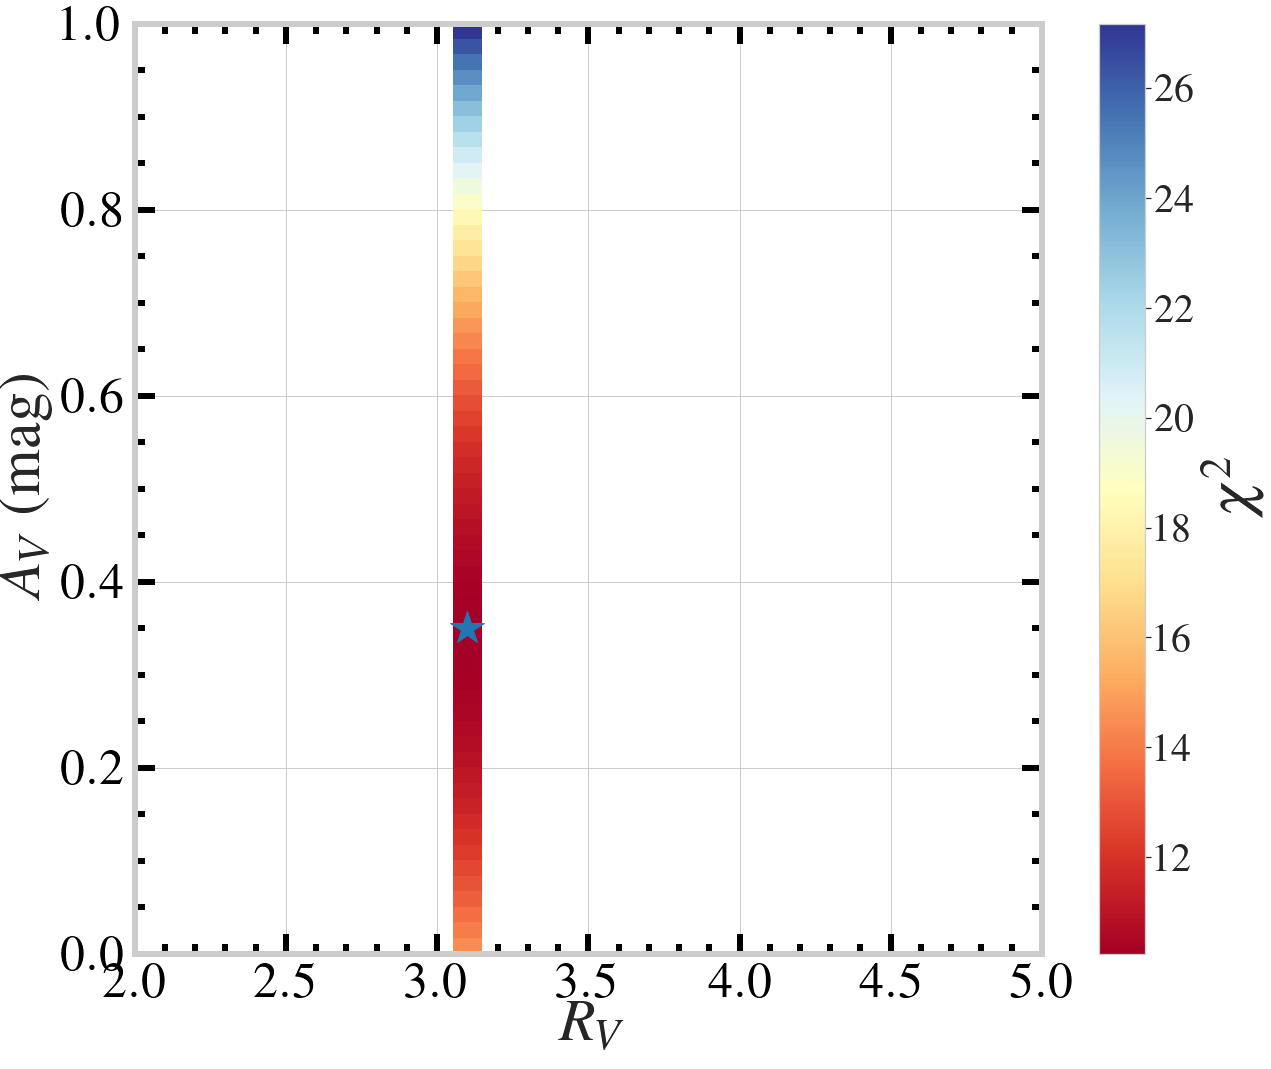

In [674]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
from matplotlib.ticker import MultipleLocator,AutoMinorLocator
import matplotlib.colors as colors

sns.set_style("whitegrid")
#sns.set_context("poster")
#sns.set(font_scale=5)  # crazy big

pad = 0.25
figsize = 10.0

def color(r,g,b):
    return((r/255.,g/255.,b/255., 1.0))

black=color(0,0,0)
red=color(255,0,0)
blue=color(10,0,255)
green=color(12,83,0)
magenta=color(204,0,204)
goldenrod=color(239,139,8)
yellow=color(255,255,0)
orange=color(204,102,0)

rc('font',**{'family':'serif','serif':['Times'],'size':5*figsize})
rc('text', usetex=True, color=black)

def setup_plot(size=[0.7, 0.7]):
    fig, ax = plt.subplots()
    for i in ax.spines.keys(): ax.spines[i].set_linewidth(0.6*figsize)
    fig.set_size_inches(1.8*figsize, 1.5*figsize)

    return(fig, ax)

def setup_axis_titles(ax, xtitle, ytitle):
    ax.set_xlabel(xtitle, labelpad=pad)
    ax.set_ylabel(ytitle, labelpad=pad)

def setup_ticks(ax):
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(direction='in', length=2*figsize, labelsize=5*figsize,
            width=0.6*figsize, which='major', axis='both', colors=black,
            pad=figsize, top=True, bottom=True, left=True, right=True)
    ax.tick_params(direction='in', length=figsize, labelsize=5*figsize,
            width=0.6*figsize, which='minor', axis='both', colors=black,
            pad=0.4*figsize, top=True, bottom=True, left=True, right=True)

#Read in Data:
Rv_list = np.load('Results/Resultsv1_Rv.npy')
Av_list  = np.load('Results/Resultsv1_Av.npy')
chi_results = np.load('Results/Resultsv1_chi.npy')

# Make the Plot: 
fig, ax = setup_plot()
setup_axis_titles(ax,r'$R_{V}$', r'$A_{V}$ (mag)')
setup_ticks(ax)

## GENERAL Plot WITH POINTS Colored based on Chi-statistic:
\

cm = plt.cm.get_cmap('RdYlBu')
for i in range(len(Rv_list)):
    Rv_plot = np.zeros(len(Av_list))+Rv_list[i]
    im = ax.scatter(Rv_plot, Av_list, c=chi_results[i,:], cmap=cm,# norm=colors.LogNorm(),
                    marker='s', s=80*figsize)

#ax.plot(Rv_list, slope*Rv_list+intercept, color=yellow, linestyle='dashed', linewidth=5)
#ax.plot(Rvrange, 0.03*Rvrange, color=yellow, linestyle='dashed', linewidth=5)
#ax.plot(Rvrange, 0.05*Rvrange, color=yellow, linestyle='dashed', linewidth=5)

#ax.text(2.7, 2.35, r'$E(B-V)$=0.78 mag',  rotation=51, color=yellow)
#ax.text(3.5, 1.06, r'$E(B-V)$=0.35 mag',  rotation=30, color=yellow)
#ax.plot(Rv_list[index[0][0]],Av_list[index[1][0]],marker='*',markersize=15,color='red')
#ax.plot([4.66667],[2.4],'*',color=yellow, ms=50)
cbar=fig.colorbar(im,ax=ax)
cbar.ax.tick_params(labelsize=4*figsize)
cbar.set_label(r'$\chi^{2}$')
#cbar.ticks([6,7,8,9,10])
#cbar.ax.set_yticklabels(['6', '7', '8', '9', '10'])
plt.plot(Rv_list[index[0][0]],Av_list[index[1][0]],marker='*',markersize=35,color='tab:blue',zorder=100)

ax.set_xlim(2.0,5.0)
ax.set_ylim(0., 1.0)

plt.tight_layout(pad=pad, w_pad=pad, h_pad=pad)
plt.savefig('2020oi_colour-chi.png', dpi=300, bbox_inches='tight')

plt.show()

In [671]:
0.15-0.02

0.13

In [685]:
EBV

0.1129032258064516

In [678]:
Rv_list[index[0][0]]

#print out correction factors across all 7 epochs
#make the other color plots to diagnose chisq values 

3.1

In [679]:
Av_list[index[1][0]]

0.35

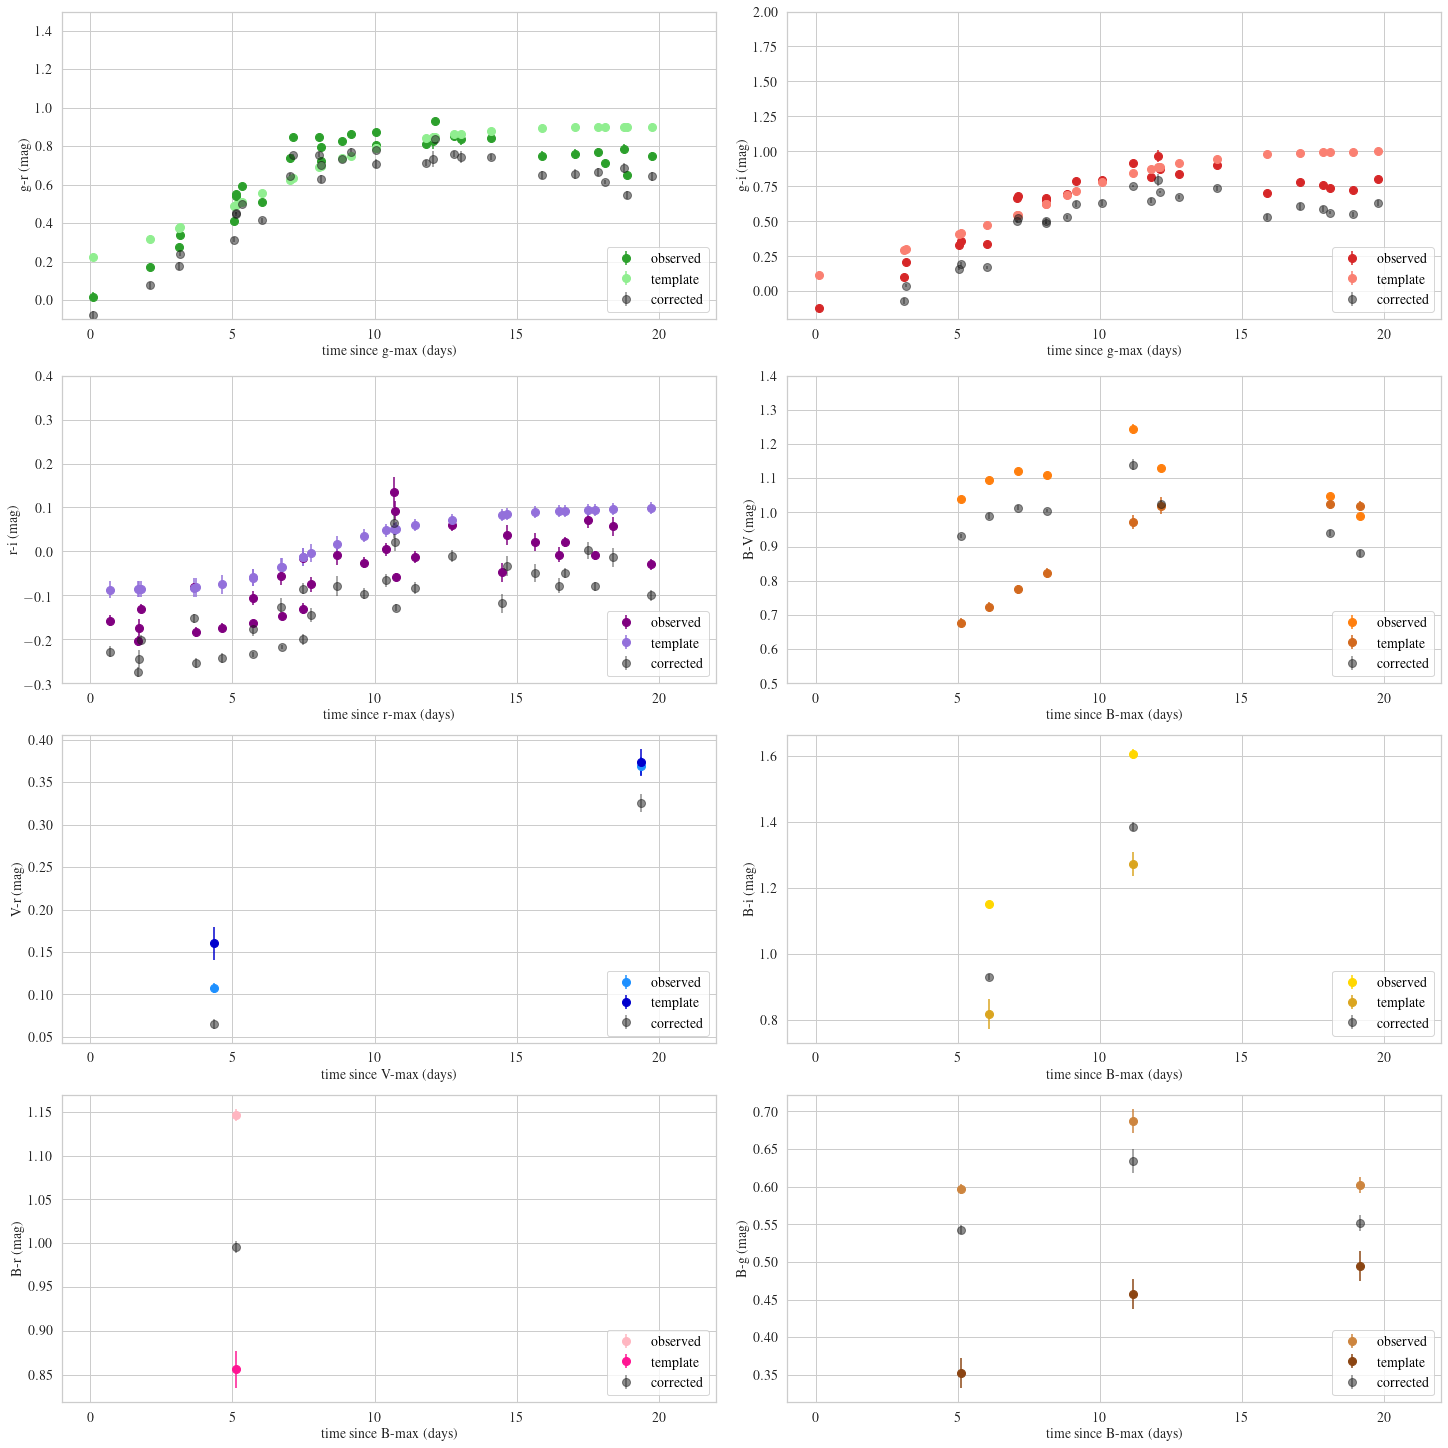

In [684]:
# Plot how well the color curves agree based on this best-fit value:

##Plot those colors and include the templates:
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
figure, subplots = plt.subplots(4, 2, figsize=(20,20), constrained_layout=True)

subplots[0,0].errorbar(gr_obs_temp['PHASE'], gr_obs_temp['COLOR_OBS'], gr_obs_temp['DCOLOR_OBS'], fmt='o', c='tab:green', label='observed', ms=8)
subplots[0,0].errorbar(gr_obs_temp['PHASE'], gr_obs_temp['COLOR_TEMP'], gr_obs_temp['DCOLOR_TEMP'], fmt='o', color='lightgreen', label='template', ms=8)
subplots[0,0].errorbar(gr_obs_temp['PHASE'], gr_best_cor, gr_obs_temp['DCOLOR_OBS'], fmt='o', color='k', label='corrected', alpha=0.5, ms=8)


subplots[0,1].errorbar(gi_obs_temp['PHASE'], gi_obs_temp['COLOR_OBS'], gi_obs_temp['DCOLOR_OBS'], fmt='o', c='tab:red', label='observed', ms=8)
subplots[0,1].errorbar(gi_obs_temp['PHASE'], gi_obs_temp['COLOR_TEMP'], gi_obs_temp['DCOLOR_TEMP'], fmt='o', color='salmon', label='template', ms=8)
subplots[0,1].errorbar(gi_obs_temp['PHASE'],  gi_best_cor, gi_obs_temp['DCOLOR_OBS'], fmt='o', color='k', label='corrected', alpha=0.5, ms=8)

subplots[1,0].errorbar(ri_obs_temp['PHASE'], ri_obs_temp['COLOR_OBS'], ri_obs_temp['DCOLOR_OBS'], fmt='o', c='purple', label='observed', ms=8)
subplots[1,0].errorbar(ri_obs_temp['PHASE'], ri_obs_temp['COLOR_TEMP'], ri_obs_temp['DCOLOR_TEMP'], fmt='o', color='mediumpurple', label='template', ms=8)
subplots[1,0].errorbar(ri_obs_temp['PHASE'], ri_best_cor, ri_obs_temp['DCOLOR_OBS'], fmt='o', color='k', label='corrected', alpha=0.5, ms=8)

subplots[1,1].errorbar(BV_obs_temp['PHASE'], BV_obs_temp['COLOR_OBS'], BV_obs_temp['DCOLOR_OBS'], fmt='o', c='tab:orange', label='observed', ms=8)
subplots[1,1].errorbar(BV_obs_temp['PHASE'], BV_obs_temp['COLOR_TEMP'], BV_obs_temp['DCOLOR_TEMP'], fmt='o', color='chocolate', label='template', ms=8)
subplots[1,1].errorbar(BV_obs_temp['PHASE'], BV_best_cor, BV_obs_temp['DCOLOR_OBS'], fmt='o', color='k', label='corrected', alpha=0.5, ms=8)

subplots[2,0].errorbar(Vr_obs_temp['PHASE'], Vr_obs_temp['COLOR_OBS'], Vr_obs_temp['DCOLOR_OBS'], fmt='o', c='dodgerblue', label='observed', ms=8)
subplots[2,0].errorbar(Vr_obs_temp['PHASE'], Vr_obs_temp['COLOR_TEMP'], Vr_obs_temp['DCOLOR_TEMP'], fmt='o', color='mediumblue', label='template', ms=8)
subplots[2,0].errorbar(Vr_obs_temp['PHASE'], Vr_best_cor, Vr_obs_temp['DCOLOR_OBS'], fmt='o', color='k', label='corrected', alpha=0.5, ms=8)

subplots[2,1].errorbar(Bi_obs_temp['PHASE'], Bi_obs_temp['COLOR_OBS'], Bi_obs_temp['DCOLOR_OBS'], fmt='o', c='gold', label='observed', ms=8)
subplots[2,1].errorbar(Bi_obs_temp['PHASE'], Bi_obs_temp['COLOR_TEMP'], Bi_obs_temp['DCOLOR_TEMP'], fmt='o', color='goldenrod', label='template', ms=8)
subplots[2,1].errorbar(Bi_obs_temp['PHASE'], Bi_best_cor, Bi_obs_temp['DCOLOR_OBS'], fmt='o', color='k', label='corrected', alpha=0.5, ms=8)

subplots[3,0].errorbar(Br_obs_temp['PHASE'], Br_obs_temp['COLOR_OBS'], Br_obs_temp['DCOLOR_OBS'], fmt='o', c='lightpink', label='observed', ms=8)
subplots[3,0].errorbar(Br_obs_temp['PHASE'], Br_obs_temp['COLOR_TEMP'], Br_obs_temp['DCOLOR_TEMP'], fmt='o', color='deeppink', label='template', ms=8)
subplots[3,0].errorbar(Br_obs_temp['PHASE'], Br_best_cor, Br_obs_temp['DCOLOR_OBS'], fmt='o', color='k', label='corrected', alpha=0.5, ms=8)


subplots[3,1].errorbar(Bg_obs_temp['PHASE'], Bg_obs_temp['COLOR_OBS'], Bg_obs_temp['DCOLOR_OBS'], fmt='o', c='peru', label='observed', ms=8)
subplots[3,1].errorbar(Bg_obs_temp['PHASE'], Bg_obs_temp['COLOR_TEMP'], Bg_obs_temp['DCOLOR_TEMP'], fmt='o', color='saddlebrown', label='template', ms=8)
subplots[3,1].errorbar(Bg_obs_temp['PHASE'], Bg_best_cor, Bg_obs_temp['DCOLOR_OBS'], fmt='o', color='k', label='corrected', alpha=0.5, ms=8)

#Bg_best_cor = Bg_obs_cor
#gV_best_cor = gV_obs_cor

subplots[0,0].set_xlim(-1,22)
subplots[0,0].set_ylim(-0.1,1.5)
subplots[0,0].set_xlabel(r'time since g-max (days)', fontsize=14) 
subplots[0,0].set_ylabel(r'g-r (mag)', fontsize=14) 
subplots[0,0].legend(loc='lower right',fontsize=14)

subplots[0,1].set_xlim(-1,22)
subplots[0,1].set_ylim(-0.2,2)
subplots[0,1].set_xlabel(r'time since g-max (days)', fontsize=14) 
subplots[0,1].set_ylabel(r'g-i (mag)', fontsize=14) 
subplots[0,1].legend(loc='lower right',fontsize=14)

subplots[1,0].set_xlim(-1,22)
subplots[1,0].set_ylim(-0.3,0.4)
subplots[1,0].set_xlabel(r'time since r-max (days)', fontsize=14) 
subplots[1,0].set_ylabel(r'r-i (mag)', fontsize=14) 
subplots[1,0].legend(loc='lower right',fontsize=14)

subplots[1,1].set_xlim(-1,22)
subplots[1,1].set_ylim(0.5,1.4)
subplots[1,1].set_xlabel(r'time since B-max (days)', fontsize=14) 
subplots[1,1].set_ylabel(r'B-V (mag)', fontsize=14) 
subplots[1,1].legend(loc='lower right',fontsize=14)

subplots[2,0].set_xlim(-1,22)
#subplots[2,0].set_ylim(-0.3,0.4)
subplots[2,0].set_xlabel(r'time since V-max (days)', fontsize=14) 
subplots[2,0].set_ylabel(r'V-r (mag)', fontsize=14) 
subplots[2,0].legend(loc='lower right',fontsize=14)

subplots[2,1].set_xlim(-1,22)
subplots[2,1].set_xlabel(r'time since B-max (days)', fontsize=14) 
subplots[2,1].set_ylabel(r'B-i (mag)', fontsize=14) 
subplots[2,1].legend(loc='lower right',fontsize=14)

subplots[3,0].set_xlim(-1,22)
subplots[3,0].set_xlabel(r'time since B-max (days)', fontsize=14) 
subplots[3,0].set_ylabel(r'B-r (mag)', fontsize=14) 
subplots[3,0].legend(loc='lower right',fontsize=14)

subplots[3,1].set_xlim(-1,22)
subplots[3,1].set_xlabel(r'time since B-max (days)', fontsize=14) 
subplots[3,1].set_ylabel(r'B-g (mag)', fontsize=14) 
subplots[3,1].legend(loc='lower right',fontsize=14)

plt.show()

## Corrected Colors versus templates:
Note: Running the first cell calculates the correction factors for all of the observed colors, not just the ones in the 0 to +20 days range. The second cell actually makes the plot. Not sure if we feel we need to show a figure like this. 

In [481]:
ebv_best

0.13333333333333333

In [480]:
#Read in the spectra:
floyds_Jan2 = ascii.read('Spectra/2019yvr.20200102.FLOYDS-N.better.flm',delimiter=' ',comment=';')
lris_Jan27 = ascii.read('Spectra/2019yvr-lris-20200127.flm',delimiter=' ',comment=';')

#Read in Results:
Rv_list = np.load('Results/Resultsv1_Rv.npy')
Av_list  = np.load('Results/Resultsv1_Av.npy')
chi_results = np.load('Results/Resultsv1_chi.npy')

##Find Best value: 
index = np.where(chi_results == np.min(chi_results))
Rv_best = Rv_list[index[0][0]]
Av_best = Av_list[index[1][0]]

ebv_best=Av_best/Rv_best

Av = np.array(Av_list)
Rv = np.array(Rv_list)

print(chi_results.shape)
print(Av.shape)
print(Rv.shape)

chi_scaled = np.array(chi_results) / np.min(chi_results)
idx = np.where(chi_scaled < 1.0 + 2.3)
ebv = []
print(idx[0])
for i in np.arange(len(idx[0])):
    ebv.append(Av_list[idx[1][i]] / Rv_list[idx[0][i]])
print(ebv_best,ebv_best-np.min(ebv), np.max(ebv)-ebv_best)
print(np.min(ebv),np.max(ebv))

print(Rv_best,Av_best)

##Read in the full color data that needs to be corrected for this: 
Bg_obs = ascii.read("FullData/Observed/SN2019yvr_Bg.csv",delimiter=',')
gV_obs = ascii.read("FullData/Observed/SN2019yvr_gV.csv",delimiter=',')
gr_obs = ascii.read("FullData/Observed/SN2019yvr_gr.csv",delimiter=',')
gi_obs = ascii.read("FullData/Observed/SN2019yvr_gi.csv",delimiter=',')

Br_obs = ascii.read("FullData/Observed/SN2019yvr_Br.csv",delimiter=',')
Vr_obs = ascii.read("FullData/Observed/SN2019yvr_Vr.csv",delimiter=',')
ri_obs = ascii.read("FullData/Observed/SN2019yvr_ri.csv",delimiter=',')

BV_obs = ascii.read("FullData/Observed/SN2019yvr_BV.csv",delimiter=',')
Bi_obs = ascii.read("FullData/Observed/SN2019yvr_Bi.csv",delimiter=',')

#Correct for Milky Way Extinction: 
AB = 0.090
AV = 0.066
Ag = 0.082
Ar = 0.057
Ai = 0.042

Bg_obsMW = Bg_obs['COLOR'] - (AB - Ag)
gV_obsMW = gV_obs['COLOR'] - (Ag - AV)
gr_obsMW = gr_obs['COLOR'] - (Ag - Ar)
gi_obsMW = gi_obs['COLOR'] - (Ag - Ai)

Br_obsMW = Br_obs['COLOR'] - (AB - Ar)
Vr_obsMW = Vr_obs['COLOR'] - (AV - Ar)
ri_obsMW = ri_obs['COLOR'] - (Ar - Ai)

BV_obsMW = BV_obs['COLOR'] - (AB - AV)
Bi_obsMW = Bi_obs['COLOR'] - (AB - Ai)


#Figure out relevant phase for each color: 
Bmax_mjd = 58854.28
gmax_mjd = 58854.89
rmax_mjd = 58856.21

Bg_obs_phase = Bg_obs['MJD'] - gmax_mjd
gV_obs_phase = gV_obs['MJD'] - gmax_mjd
gr_obs_phase = gr_obs['MJD'] - gmax_mjd
gi_obs_phase = gi_obs['MJD'] - gmax_mjd

Br_obs_phase = Br_obs['MJD'] - rmax_mjd
Vr_obs_phase = Vr_obs['MJD'] - rmax_mjd
ri_obs_phase = ri_obs['MJD'] - rmax_mjd

BV_obs_phase = BV_obs['MJD'] - Bmax_mjd
Bi_obs_phase = Bi_obs['MJD'] - Bmax_mjd

################################################################
##Go through the process from above for calculating corrections: 
################################################################

#Figure out gri corrections for both spectra for this combo of Rv and Av:
A_B_floyds = A_lam(floyds_Jan2,B_filt,Rv_best,Av_best)
A_V_floyds = A_lam(floyds_Jan2,V_filt,Rv_best,Av_best)
A_g_floyds = A_lam(floyds_Jan2,g_filt,Rv_best,Av_best)
A_r_floyds = A_lam(floyds_Jan2,r_filt,Rv_best,Av_best)
A_i_floyds = A_lam(floyds_Jan2,i_filt,Rv_best,Av_best)
A_B_floyds_Feb01 = A_lam(lris_Jan27,B_filt,Rv_best,Av_best)
A_V_floyds_Feb01 = A_lam(lris_Jan27,V_filt,Rv_best,Av_best)
A_g_floyds_Feb01 = A_lam(lris_Jan27,g_filt,Rv_best,Av_best)
A_r_floyds_Feb01 = A_lam(lris_Jan27,r_filt,Rv_best,Av_best)
A_i_floyds_Feb01 = A_lam(lris_Jan27,i_filt,Rv_best,Av_best)

#Interpolate the corrections in each band to be corrections at each time step in the three templates above:
B_cor_Bgtimes = np.interp(Bg_obs_phase,np.array([-4.89,20.11]),np.array([A_B_floyds_Jan20,A_B_floyds_Feb01]))
B_cor_BVtimes = np.interp(BV_obs_phase,np.array([-4.28,20.72]),np.array([A_B_floyds_Jan20,A_B_floyds_Feb01]))
B_cor_Brtimes = np.interp(Br_obs_phase,np.array([-6.21,18.79]),np.array([A_B_floyds_Jan20,A_B_floyds_Feb01]))
B_cor_Bitimes = np.interp(Bi_obs_phase,np.array([-4.28,20.72]),np.array([A_B_floyds_Jan20,A_B_floyds_Feb01]))

g_cor_Bgtimes = np.interp(Bg_obs_phase,np.array([-4.89,20.11]),np.array([A_g_floyds_Jan20,A_g_floyds_Feb01]))
g_cor_gVtimes = np.interp(gV_obs_phase,np.array([-4.89,20.11]),np.array([A_g_floyds_Jan20,A_g_floyds_Feb01]))
g_cor_grtimes = np.interp(gr_obs_phase,np.array([-4.89,20.11]),np.array([A_g_floyds_Jan20,A_g_floyds_Feb01]))
g_cor_gitimes = np.interp(gi_obs_phase,np.array([-4.89,20.11]),np.array([A_g_floyds_Jan20,A_g_floyds_Feb01]))

V_cor_BVtimes = np.interp(BV_obs_phase,np.array([-4.28,20.72]),np.array([A_V_floyds_Jan20,A_V_floyds_Feb01]))
V_cor_gVtimes = np.interp(gV_obs_phase,np.array([-4.89,20.11]),np.array([A_V_floyds_Jan20,A_V_floyds_Feb01]))
V_cor_Vrtimes = np.interp(Vr_obs_phase,np.array([-6.21,18.79]),np.array([A_V_floyds_Jan20,A_V_floyds_Feb01]))

r_cor_Brtimes = np.interp(Br_obs_phase,np.array([-6.21,18.79]),np.array([A_r_floyds_Jan20,A_r_floyds_Feb01]))
r_cor_grtimes = np.interp(gr_obs_phase,np.array([-4.89,20.11]),np.array([A_r_floyds_Jan20,A_r_floyds_Feb01]))
r_cor_Vrtimes = np.interp(Vr_obs_phase,np.array([-6.21,18.79]),np.array([A_r_floyds_Jan20,A_r_floyds_Feb01]))
r_cor_ritimes = np.interp(ri_obs_phase,np.array([-6.21,18.79]),np.array([A_r_floyds_Jan20,A_r_floyds_Feb01]))

i_cor_Bitimes = np.interp(Bi_obs_phase,np.array([-4.28,20.72]),np.array([A_i_floyds_Jan20,A_i_floyds_Feb01]))
i_cor_gitimes = np.interp(gi_obs_phase,np.array([-4.89,20.11]),np.array([A_i_floyds_Jan20,A_i_floyds_Feb01]))
i_cor_ritimes = np.interp(ri_obs_phase,np.array([-6.21,18.79]),np.array([A_i_floyds_Jan20,A_i_floyds_Feb01]))

#Correct each of the observed light curves for this amount of extinction:
Bg_obs_cor = Bg_obsMW - (B_cor_Bgtimes - g_cor_Bgtimes)
gV_obs_cor = gV_obsMW - (g_cor_gVtimes - V_cor_gVtimes)
gr_obs_cor = gr_obsMW - (g_cor_grtimes - r_cor_grtimes)
gi_obs_cor = gi_obsMW - (g_cor_gitimes - i_cor_gitimes)

Br_obs_cor = Br_obsMW - (B_cor_Brtimes - r_cor_Brtimes)
Vr_obs_cor = Vr_obsMW - (V_cor_Vrtimes - r_cor_Vrtimes)
ri_obs_cor = ri_obsMW - (r_cor_ritimes - i_cor_ritimes)

BV_obs_cor = BV_obsMW - (B_cor_BVtimes - V_cor_BVtimes)
Bi_obs_cor = Bi_obsMW - (B_cor_Bitimes - i_cor_Bitimes)



(61, 61)
(61,)
(61,)
[ 0  0  0 ... 60 60 60]
0.13333333333333333 0.13333333333333333 0.2666666666666667
0.0 0.4
1.0 0.13333333333333333


AttributeError: 'Column' object has no attribute 'values'

(2, 2)


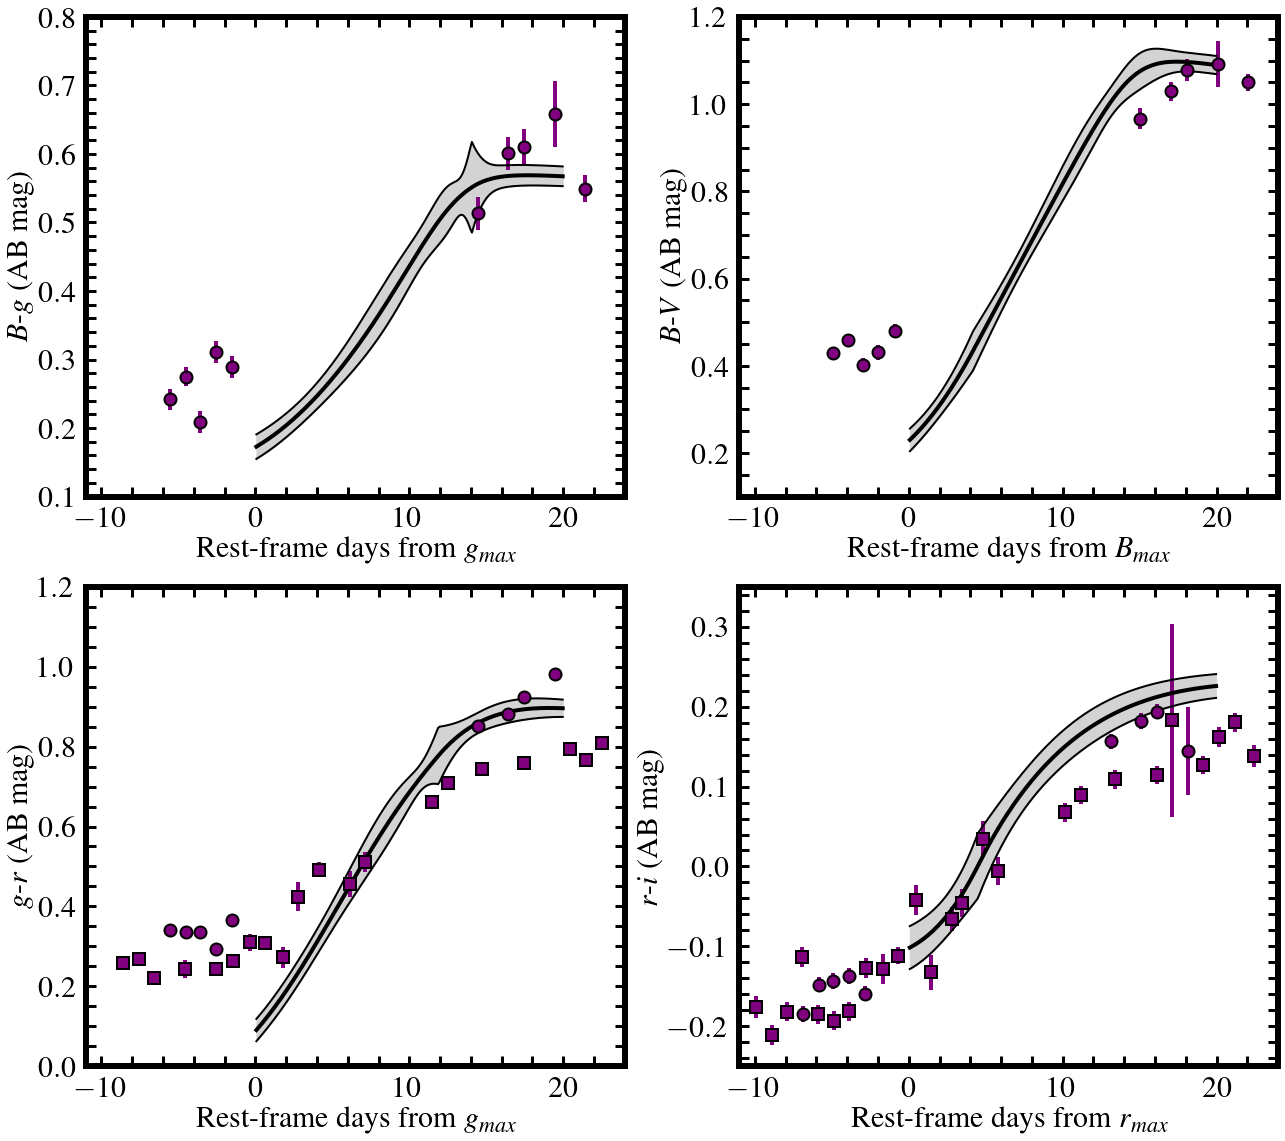

In [30]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
from matplotlib.ticker import MultipleLocator,AutoMinorLocator

pad = 0.25
figsize = 10.0

def color(r,g,b):
    return((r/255.,g/255.,b/255., 1.0))

black=color(0,0,0)
red=color(255,0,0)
blue=color(10,0,255)
green=color(12,83,0)
magenta=color(204,0,204)
goldenrod=color(239,139,8)
orange=color(204,102,0)

rc('font',**{'family':'serif','serif':['Times'],'size':5*figsize})
rc('text', usetex=True, color=black)

def setup_plot(size=[1.8, 1.5]):
    fig, ax = plt.subplots(2, 2)
    print(ax.shape)
    for j in np.arange(2):
        for k in np.arange(2):
            for i in ax[j,k].spines.keys(): ax[j,k].spines[i].set_linewidth(0.6*figsize)
    fig.set_size_inches(1.8*figsize, 1.6*figsize)

    return(fig, ax)

def setup_axis_titles(ax, xtitle, ytitle):
    ax.set_xlabel(xtitle, labelpad=pad)
    ax.set_ylabel(ytitle, labelpad=pad)

def setup_ticks(ax):

    for j in np.arange(2):
        for k in np.arange(2):
            ax[j,k].xaxis.set_minor_locator(AutoMinorLocator())
            ax[j,k].yaxis.set_minor_locator(AutoMinorLocator())

            ax[j,k].tick_params(direction='in', length=figsize, labelsize=3*figsize,
                width=0.3*figsize, which='major', axis='both', colors=black,
                pad=figsize, top=True, bottom=True, left=True, right=True)
            ax[j,k].tick_params(direction='in', length=figsize, labelsize=3*figsize,
                width=0.3*figsize, which='minor', axis='both', colors=black,
                pad=0.4*figsize, top=True, bottom=True, left=True, right=True)

#Read in the full templates:
gr_template = ascii.read('FullData/Templates/gmr_template_Ib_kcorr.mat.txt',delimiter=' ',comment=';')
gi_template = ascii.read('FullData/Templates/gmi_template_Ib_kcorr.mat.txt',delimiter=' ',comment=';')
gV_template = ascii.read('FullData/Templates/gmv_template_Ib_kcorr.mat.txt',delimiter=' ',comment=';')
Bg_template = ascii.read('FullData/Templates/bmg_template_Ib_kcorr.mat.txt',delimiter=' ',comment=';')
ri_template = ascii.read('FullData/Templates/rmi_template_Ib_kcorr.mat.txt',delimiter=' ',comment=';')
Vr_template = ascii.read('FullData/Templates/vmr_template_Ib_kcorr.mat.txt',delimiter=' ',comment=';')
Br_template = ascii.read('FullData/Templates/bmr_template_Ib_kcorr.mat.txt',delimiter=' ',comment=';')
BV_template = ascii.read('FullData/Templates/bmv_template_Ib_kcorr.mat.txt',delimiter=' ',comment=';')
Bi_template = ascii.read('FullData/Templates/bmi_template_Ib_kcorr.mat.txt',delimiter=' ',comment=';')

##Plot those colors and include the templates:
fig, ax = setup_plot()
setup_ticks(ax)
xlim=(-11,24)


#B-g [0,0]
##############
#subplots[0,0].errorbar(Bg_obs_phase,Bg_obsMW,Bg_obs['DCOLOR'],fmt ='o',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2,color='mediumpurple',label='observed')
ax[0,0].errorbar(Bg_obs_phase,Bg_obs_cor,Bg_obs['DCOLOR'],fmt ='o',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2,color='purple',label='corrected')

ax[0,0].plot(Bg_template['tg'],Bg_template['color'],linewidth=4,color='black',label='template')
ax[0,0].plot(Bg_template['tg'],Bg_template['color']+Bg_template['uncertainty'],color='black',linewidth=2,linestyle='-')
ax[0,0].plot(Bg_template['tg'],Bg_template['color']-Bg_template['uncertainty'],color='black',linewidth=2,linestyle='-')
ax[0,0].fill_between(Bg_template['tg'],Bg_template['color']+Bg_template['uncertainty'],Bg_template['color']-Bg_template['uncertainty'],
                    color=color(211,211,211))

ax[0,0].set_xlabel(r'Rest-frame days from $g_{max}$', fontsize=3*figsize) 
ax[0,0].set_ylabel(r'$B$-$g$ (AB mag)', fontsize=3*figsize) 
ax[0,0].set_xlim(*xlim)
ax[0,0].set_ylim(0.1,0.8)

#B-V [0,1]
##############
#subplots[0,1].errorbar(BV_obs_phase,BV_obsMW,BV_obs['DCOLOR'],fmt ='o',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2,color='mediumpurple',label='observed')
ax[0,1].errorbar(BV_obs_phase,BV_obs_cor,BV_obs['DCOLOR'],fmt ='o',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2,color='purple',label='corrected')

ax[0,1].plot(BV_template['tB'],BV_template['color'],linewidth=4,color='black',label='template')
ax[0,1].plot(BV_template['tB'],BV_template['color']+BV_template['uncertainty'],color='black',linewidth=2,linestyle='-')
ax[0,1].plot(BV_template['tB'],BV_template['color']-BV_template['uncertainty'],color='black',linewidth=2,linestyle='-')
ax[0,1].fill_between(BV_template['tB'],BV_template['color']+BV_template['uncertainty'],BV_template['color']-BV_template['uncertainty'],
                    color=color(211,211,211))

ax[0,1].set_xlabel(r'Rest-frame days from $B_{max}$', fontsize=3*figsize) 
ax[0,1].set_ylabel(r'$B$-$V$ (AB mag)', fontsize=3*figsize) 
ax[0,1].set_xlim(*xlim)
ax[0,1].set_ylim(0.1,1.2)

#g-r [2,0]
##############
indexS = np.where(gr_obs['INST'] == 'Swope')[0] #plot as circle
indexL = np.where(gr_obs['INST'] == 'lcogt')[0] #plot as square
#subplots[2,0].errorbar(gr_obs_phase[indexS],gr_obsMW[indexS],gr_obs['DCOLOR'][indexS],fmt ='o',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2,color='mediumpurple',label='observed')
#subplots[2,0].errorbar(gr_obs_phase[indexL],gr_obsMW[indexL],gr_obs['DCOLOR'][indexL],fmt ='s',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2,color='mediumpurple')
ax[1,0].errorbar(gr_obs_phase[indexS],gr_obs_cor[indexS],gr_obs['DCOLOR'][indexS],fmt ='o',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2,color='purple',label='corrected')
ax[1,0].errorbar(gr_obs_phase[indexL],gr_obs_cor[indexL],gr_obs['DCOLOR'][indexL],fmt ='s',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2,color='purple')

ax[1,0].plot(gr_template['tg'],gr_template['color'],linewidth=4,color='black',label='template')
ax[1,0].plot(gr_template['tg'],gr_template['color']+gr_template['uncertainty'],color='black',linewidth=2,linestyle='-')
ax[1,0].plot(gr_template['tg'],gr_template['color']-gr_template['uncertainty'],color='black',linewidth=2,linestyle='-')
ax[1,0].fill_between(gr_template['tg'],gr_template['color']+gr_template['uncertainty'],gr_template['color']-gr_template['uncertainty'],
                    color=color(211,211,211))


ax[1,0].set_xlabel(r'Rest-frame days from $g_{max}$', fontsize=3*figsize) 
ax[1,0].set_ylabel(r'$g$-$r$ (AB mag)', fontsize=3*figsize) 
ax[1,0].set_xlim(*xlim)
ax[1,0].set_ylim(0.0,1.2)

#r-i [2,2]
##############
indexS = np.where(ri_obs['INST'] == 'Swope')[0] #plot as circle
indexL = np.where(ri_obs['INST'] == 'lcogt')[0] #plot as square
#subplots[2,2].errorbar(ri_obs_phase[indexS],ri_obsMW[indexS],ri_obs['DCOLOR'][indexS],fmt ='o',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2,color='mediumpurple',label='observed')
#subplots[2,2].errorbar(ri_obs_phase[indexL],ri_obsMW[indexL],ri_obs['DCOLOR'][indexL],fmt ='s',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2,color='mediumpurple')
ax[1,1].errorbar(ri_obs_phase[indexS],ri_obs_cor[indexS],ri_obs['DCOLOR'][indexS],fmt ='o',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2,color='purple',label='corrected')
ax[1,1].errorbar(ri_obs_phase[indexL],ri_obs_cor[indexL],ri_obs['DCOLOR'][indexL],fmt ='s',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2,color='purple')

ax[1,1].plot(ri_template['tr'],ri_template['color'],linewidth=4,color='black',label='template')
ax[1,1].plot(ri_template['tr'],ri_template['color']+ri_template['uncertainty'],color='black',linewidth=2,linestyle='-')
ax[1,1].plot(ri_template['tr'],ri_template['color']-ri_template['uncertainty'],color='black',linewidth=2,linestyle='-')
ax[1,1].fill_between(ri_template['tr'],ri_template['color']+ri_template['uncertainty'],ri_template['color']-ri_template['uncertainty'],
                    color=color(211,211,211))


ax[1,1].set_xlabel(r'Rest-frame days from $r_{max}$', fontsize=3*figsize) 
ax[1,1].set_ylabel(r'$r$-$i$ (AB mag)', fontsize=3*figsize) 
ax[1,1].set_xlim(*xlim)
ax[1,1].set_ylim(-0.25,0.35)

plt.tight_layout(pad=pad, w_pad=pad, h_pad=pad)
plt.savefig('2019yvr-colour-curves.eps', format='eps')

plt.show()

## Light Curve Plot:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


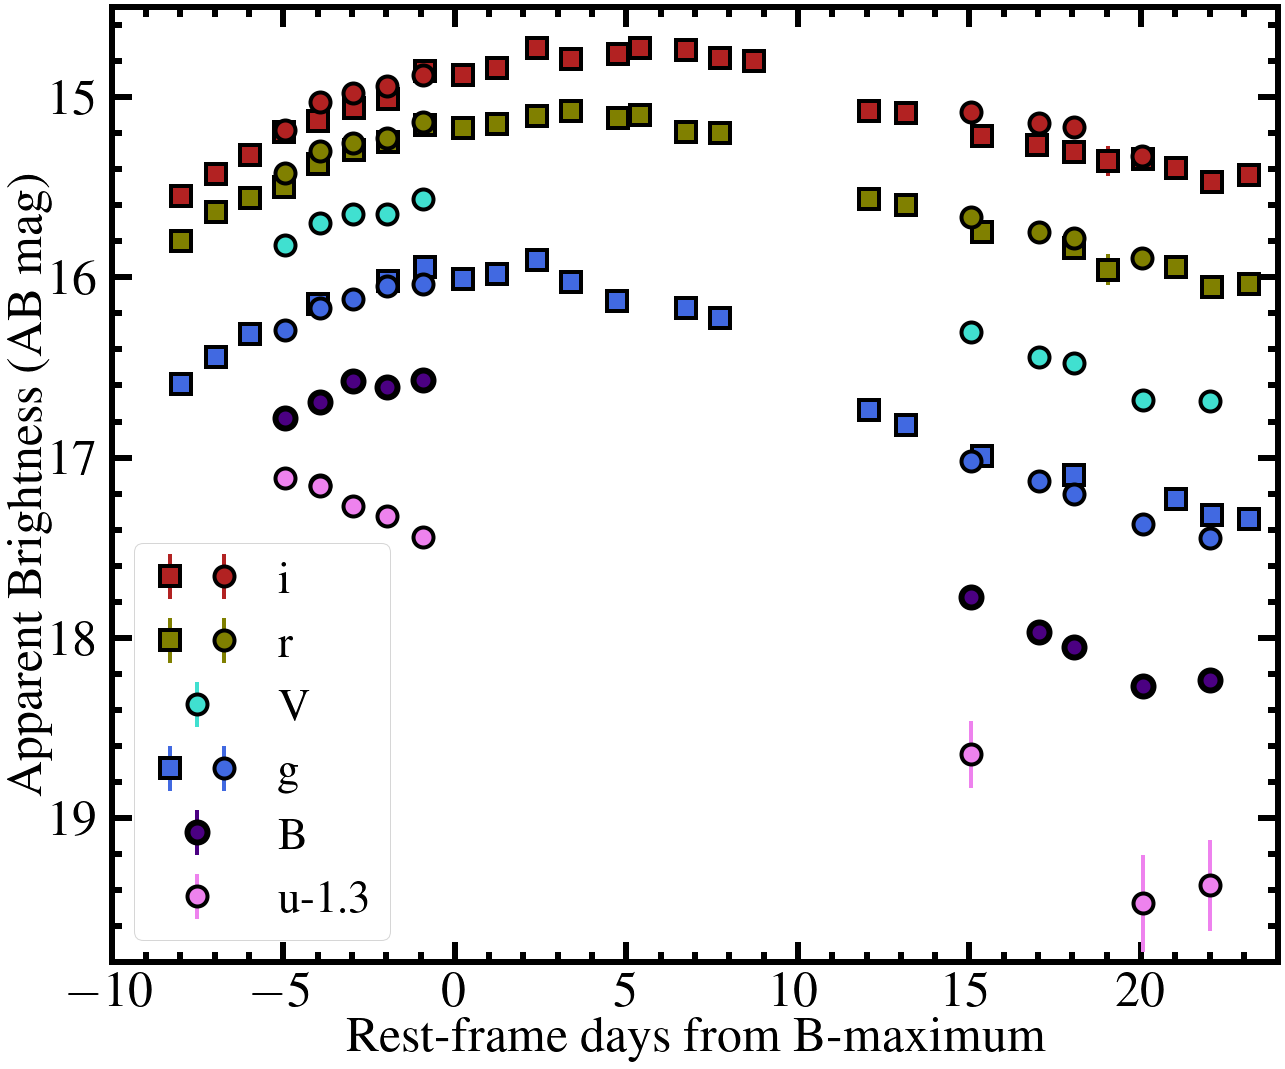

In [18]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
from matplotlib.ticker import MultipleLocator,AutoMinorLocator

pad = 0.25
figsize = 10.0

def color(r,g,b):
    return((r/255.,g/255.,b/255., 1.0))

black=color(0,0,0)
red=color(255,0,0)
blue=color(10,0,255)
green=color(12,83,0)
magenta=color(204,0,204)
goldenrod=color(239,139,8)
orange=color(204,102,0)

rc('font',**{'family':'serif','serif':['Times'],'size':5*figsize})
rc('text', usetex=True, color=black)

def setup_plot(size=[1.8, 1.5]):
    fig, ax = plt.subplots()
    for i in ax.spines.keys(): ax.spines[i].set_linewidth(0.6*figsize)
    fig.set_size_inches(1.8*figsize, 1.5*figsize)

    return(fig, ax)

def setup_axis_titles(ax, xtitle, ytitle):
    ax.set_xlabel(xtitle, labelpad=pad)
    ax.set_ylabel(ytitle, labelpad=pad)

def setup_ticks(ax):

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(direction='in', length=2*figsize, labelsize=5*figsize,
            width=0.6*figsize, which='major', axis='both', colors=black,
            pad=figsize, top=True, bottom=True, left=True, right=True)
    ax.tick_params(direction='in', length=figsize, labelsize=5*figsize,
            width=0.6*figsize, which='minor', axis='both', colors=black,
            pad=0.4*figsize, top=True, bottom=True, left=True, right=True)

# Read in the Light Curves:
u_lc = ascii.read('FullData/Observed/SN2019yvr_u_final.csv',format='csv')
B_lc = ascii.read('FullData/Observed/SN2019yvr_B_final.csv',format='csv')
V_lc = ascii.read('FullData/Observed/SN2019yvr_V_final.csv',format='csv')
g_lc = ascii.read('FullData/Observed/SN2019yvr_g_final.csv',format='csv')
r_lc = ascii.read('FullData/Observed/SN2019yvr_r_final.csv',format='csv')
i_lc = ascii.read('FullData/Observed/SN2019yvr_i_final.csv',format='csv')

# Make Phases Relative to Max Light:
Bmax_mjd = 58854.28

u_phase = u_lc['MJD'] - Bmax_mjd
B_phase = B_lc['MJD'] - Bmax_mjd
V_phase = V_lc['MJD'] - Bmax_mjd
g_phase = g_lc['MJD'] - Bmax_mjd
r_phase = r_lc['MJD'] - Bmax_mjd
i_phase = i_lc['MJD'] - Bmax_mjd

# Set the offsets:
u_off = -1.3
B_off = 0.0
V_off = 0.0
g_off = 0.0
r_off = 0.0
i_off = 0.0

#Set the colors:
ucolor = 'violet'
Bcolor = 'indigo' 
Vcolor = 'turquoise'
gcolor = 'royalblue'
rcolor = 'olive'
icolor = 'firebrick'

# Make the Plot: 
fig, ax = setup_plot()
setup_axis_titles(ax, r'Rest-frame days from B-maximum', r'Apparent Brightness (AB mag)')
setup_ticks(ax)

indexS = np.where(i_lc['INST'] == 'Swope')[0] #plot as circle
indexL = np.where(i_lc['INST'] == 'lcogt')[0] #plot as square
li=ax.errorbar(i_phase[indexL],i_lc['MAG'][indexL]+i_off,i_lc['DMAG'][indexL],fmt ='s',markersize=2*figsize,elinewidth=4,markeredgecolor='k',markeredgewidth=0.4*figsize,color=icolor)#,label='i')
si=ax.errorbar(i_phase[indexS],i_lc['MAG'][indexS]+i_off,i_lc['DMAG'][indexS],fmt ='o',markersize=2*figsize,elinewidth=4,markeredgecolor='k',markeredgewidth=0.4*figsize,color=icolor,label='i')

indexS = np.where(r_lc['INST'] == 'Swope')[0] #plot as circle
indexL = np.where(r_lc['INST'] == 'lcogt')[0] #plot as square
lr=ax.errorbar(r_phase[indexL],r_lc['MAG'][indexL]+r_off,r_lc['DMAG'][indexL],fmt ='s',markersize=2*figsize,elinewidth=4,markeredgecolor='k',markeredgewidth=0.4*figsize,color=rcolor)#,label='r')
sr=ax.errorbar(r_phase[indexS],r_lc['MAG'][indexS]+r_off,r_lc['DMAG'][indexS],fmt ='o',markersize=2*figsize,elinewidth=4,markeredgecolor='k',markeredgewidth=0.4*figsize,color=rcolor,label='r')

sv=ax.errorbar(V_phase,V_lc['MAG']+V_off,V_lc['DMAG'],fmt ='o',markersize=2*figsize,elinewidth=4,markeredgecolor='k',markeredgewidth=0.4*figsize,color=Vcolor,label='V')

indexS = np.where(g_lc['INST'] == 'Swope')[0] #plot as circle
indexL = np.where(g_lc['INST'] == 'lcogt')[0] #plot as square
lg=ax.errorbar(g_phase[indexL],g_lc['MAG'][indexL]+g_off,g_lc['DMAG'][indexL],fmt ='s',markersize=2*figsize,elinewidth=4,markeredgecolor='k',markeredgewidth=0.4*figsize,color=gcolor)#,label='g')
sg=ax.errorbar(g_phase[indexS],g_lc['MAG'][indexS]+g_off,g_lc['DMAG'][indexS],fmt ='o',markersize=2*figsize,elinewidth=4,markeredgecolor='k',markeredgewidth=0.4*figsize,color=gcolor,label='g')

indexS = np.where(u_lc['INST'] == 'Swope')[0] #plot as circle
su=ax.errorbar(u_phase[indexS],u_lc['MAG'][indexS]+u_off,u_lc['DMAG'][indexS],fmt ='o',markersize=2*figsize,elinewidth=4,markeredgecolor='k',markeredgewidth=0.4*figsize,color=ucolor,label='u')



sb=ax.errorbar(B_phase,B_lc['MAG']+B_off,B_lc['DMAG'],fmt ='o',markersize=2*figsize,elinewidth=4,markeredgecolor='k',markeredgewidth=0.6*figsize,color=Bcolor,label='B')

ax.set_xlim(-10,24)
ax.set_ylim(19.8,14.5)

from matplotlib.legend_handler import HandlerTuple

ax.legend([(li,si),(lr,sr),(sv),(lg,sg),(sb),(su)],['i','r','V','g','B','u-1.3'],loc='lower left', fontsize=4.5*figsize,
         scatterpoints=1, numpoints=1, handler_map={tuple: HandlerTuple(ndivide=None)})

plt.tight_layout(pad=pad, w_pad=pad, h_pad=pad)
plt.savefig('2019yvr-lightcurve.eps', format='eps')

#plt.show()